# Bibliotecas e Configurações

In [111]:
import pandas as pd
import numpy as np

import csv

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.api import SimpleExpSmoothing

import warnings
warnings.filterwarnings('ignore')

# Objetivo

O objetivo deste projeto é ....

# Base de Dados

Comentários gerais das bases de dados

- df_dados_gerais.csv
    - Arquivo onde consta a quantidade de alunos e profissionais (bolsistas, universitários, professores, psicólogos, psicopedagogos, psiquiatras, assistentes sociais) envolvidos nas atividades da ONG em cada um dos anos

<BR>

- PEDE_PASSOS_DATASET_FIAP.csv
    - Arquivo disponibilizado pelo pessoal da Passos Mágicos onde constam as informações de acompanhamento de cada aluno (notas, indicadores, observações, etc) durante o período em que ele esteve na ONG 

Convertendo o arquivo disponibilizado pelo pessoal da Passos Mágicos (PEDE_PASSOS_DATASET_FIAP.csv) em um padrão que é orientado a linhas em vez de colunas:

In [112]:
df = pd.read_csv("dados/PEDE_PASSOS_DATASET_FIAP.csv", delimiter = ";", decimal = ".", na_values = None)

colunas2020 = []
colunas2021 = []
colunas2022 = []

for c in df.columns:
    if "_2020" in c:
        colunas2020.append(c.replace("_2020", ""))
    elif "_2021" in c:
        colunas2021.append(c.replace("_2021", ""))
    elif "_2022" in c:
        colunas2022.append(c.replace("_2022", ""))

colunasParaAdicionar = []
for coluna in colunas2020:
    if coluna not in colunas2021:
        colunasParaAdicionar.append(coluna+"_2021")
    if coluna not in colunas2022:
        colunasParaAdicionar.append(coluna+"_2022")

for coluna in colunas2021:
    if coluna not in colunas2020:
        colunasParaAdicionar.append(coluna+"_2020")
    if coluna not in colunas2022:
        colunasParaAdicionar.append(coluna+"_2022")

for coluna in colunas2022:
    if coluna not in colunas2020:
        colunasParaAdicionar.append(coluna+"_2020")
    if coluna not in colunas2021:
        colunasParaAdicionar.append(coluna+"_2021")

for coluna in colunasParaAdicionar:
    df[coluna] = None # np.NaN

# Substituir NaN por None
df = df.where(pd.notna(df), None)

# Expressões regulares para identificar as colunas que começam com 2020, 2021 e 2022
colunas_relevantes = df.filter(regex=r'_20(20|21|22)$')

df_melted = pd.melt(df, id_vars=['NOME'], value_vars=colunas_relevantes, var_name='VARIAVEL_ANO', value_name='VALOR')

dict = {}

for index in range(len(df_melted)):
    linha = df_melted.iloc[index]
    aluno    = linha[0]
    variavel = linha[1]
    valor    = linha[2]
    dados = variavel.rsplit('_', 1)[0]
    ano = variavel.rsplit('_', 1)[-1]
    if aluno not in dict:
        dict[aluno] = {}
    if ano not in dict[aluno]:
        dict[aluno][ano] = {}
    if dados not in dict[aluno][ano]:
        dict[aluno][ano][dados] = valor
    if isinstance(valor, float):
        dict[aluno][ano][dados] = round(valor, 2)
    else:
        dict[aluno][ano][dados] = valor

for aluno in dict:
    for ano in dict[aluno]:
        for dados in dict[aluno][ano]:
            valor = dict[aluno][ano][dados]
            # print(aluno, ano, dados, valor)

colunasCertas = []
colunas = df_melted['VARIAVEL_ANO'].unique()
for coluna in colunas:
    colunasCertas.append(coluna.replace("_2020", "").replace("_2021", "").replace("_2022", ""))

colunasCertas = list(set(colunasCertas))

colunasCertas.insert(0, "ANO")
colunasCertas.insert(0, "ALUNO")

teste = {}
for coluna in colunasCertas:
    teste[coluna] = []

for aluno in dict:
    for ano in dict[aluno]:
        teste["ALUNO"].append(aluno)
        teste["ANO"].append(ano)
        for dados in dict[aluno][ano]:
            valor = dict[aluno][ano][dados]
            teste[dados].append(valor)
            # print(aluno, ano, dados, valor)

todasLinhas = []
linhaCabecalho = []
for coluna_cabecalho in teste:
    linhaCabecalho.append(coluna_cabecalho)
todasLinhas.append(linhaCabecalho)

# Obtendo o número total de posições nos arrays
num_posicoes = len(teste['ALUNO'])

# Loop para iterar sobre as posições nos arrays
for posicao in range(num_posicoes):
    # Loop para iterar sobre as chaves do dicionário
    linha = []
    for chave, array in teste.items():
        linha.append(array[posicao])
    # print(linha)
    # print()
    todasLinhas.append(linha)
    linha = []
    

with open('dados/dados.csv', 'w', newline = "") as myFile:
    wr = csv.writer(myFile, delimiter = ";") #, quoting=csv.QUOTE_ALL)
    wr.writerows(todasLinhas)
myFile.close()

In [113]:
# Lendo o arquivo CSV gerado e transformando ele em um XLSX antes de lê-lo
df = pd.read_csv("dados/dados.csv", sep = ";", encoding = "iso-8859-1")
df.to_excel("dados/dados.xlsx", index = False)
df = pd.read_excel("dados/dados.xlsx")

# Ajustando algumas colunas do DF
df['INDE']  = pd.to_numeric(df['INDE'], errors='coerce')
df['IAA']   = pd.to_numeric(df['IAA'], errors='coerce')
df['IEG']   = pd.to_numeric(df['IEG'], errors='coerce')
df['IPS']   = pd.to_numeric(df['IPS'], errors='coerce')
df['IDA']   = pd.to_numeric(df['IDA'], errors='coerce')
df['IPP']   = pd.to_numeric(df['IPP'], errors='coerce')
df['IPV']   = pd.to_numeric(df['IPV'], errors='coerce')
df['IAN']   = pd.to_numeric(df['IAN'], errors='coerce')

# Criando uma coluna para conseguir ordenar os alunos de acordo com o número deles
df['NUMERO_ALUNO'] = df['ALUNO'].str.split('-').str[1].astype(int)

# Apagando os dados dos alunos que acabaram sendo disponibilizados com erros
df.drop(df[(df['ALUNO'] == 'ALUNO-1259')].index, inplace = True)
df.drop(df[df['PONTO_VIRADA'] == '#NULO!'].index, inplace = True)

In [114]:
df.shape

(4042, 44)

In [115]:
df.head()

,ALUNO,ANO,PEDRA,DESTAQUE_IPV,DESTAQUE_IDA,TURMA,ANOS_PM,REC_EQUIPE_4,REC_EQUIPE_2,SINALIZADOR_INGRESSANTE,...,IEG,PONTO_VIRADA,REC_AVA_2,NIVEL_IDEAL,INDE,CG,INDE_CONCEITO,FASE,REC_AVA_1,NUMERO_ALUNO
0,ALUNO-1,2020,Ametista,Seu destaque em 2020: A sua boa integração aos...,Ponto a melhorar em 2021: Empenhar-se mais nas...,NaN,2,NaN,NaN,NaN,...,8.7,Não,NaN,NaN,7.883752,NaN,B,NaN,NaN,1
1,ALUNO-1,2021,Ametista,NaN,NaN,G,NaN,Não avaliado,Promovido de Fase,Ingressante,...,6.3,Não,NaN,Nível 3 (7o e 8o ano),7.319000,NaN,NaN,2.0,NaN,1
2,ALUNO-1,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,ALUNO-2,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
4,ALUNO-2,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


Ponto de Virada é o estágio do desenvolvimento do aluno, no qual ele demonstra de forma ativa, diversas dimensões da sua trajetória dentro da Associação. O aluno precisa estar **consciente da importância da educação**, do valor do saber e da importância de aprender. Passar pelo Ponto de Virada deve significar estar apto a iniciar a transformação da sua vida por meio da educação.
<BR><BR>
Tendo isso em vista, vamos analisar alguns fatores possivelmente envolvidos com o Ponto de Virada.

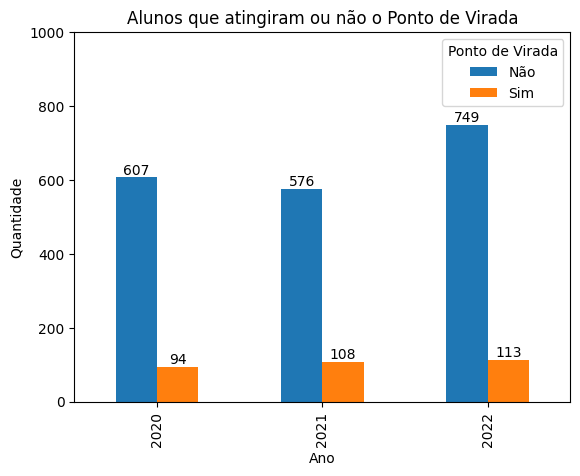

In [116]:
df_ponto_virada = df.groupby(["ANO", "PONTO_VIRADA"])["PONTO_VIRADA"].count().unstack().fillna(0) # df[df['PONTO_VIRADA'] == "Sim"].groupby(["ANO"])["PONTO_VIRADA"].count()
df_ponto_virada

ax = df_ponto_virada.plot.bar()

for container in ax.containers:
    ax.bar_label(container)

ax.set_ylim([0,1000])
ax.set_title("Alunos que atingiram ou não o Ponto de Virada")
ax.set_xlabel("Ano")
ax.set_ylabel("Quantidade")
ax.legend(title="Ponto de Virada")

plt.show()

Podemos ver que o Ponto de Virada é atingido por uma baixa % (na casa dos 13 ~ 15%) dos alunos em cada um dos anos em que foram disponibilizados dados

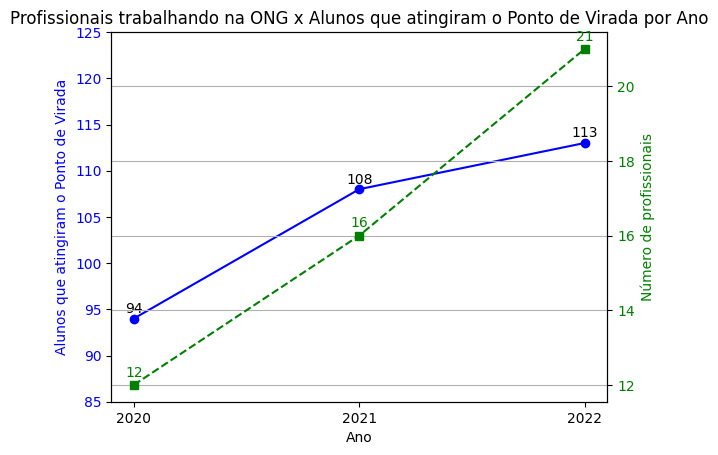

In [117]:
df_ponto_virada_sim = df[df['PONTO_VIRADA'] == "Sim"].groupby(["ANO"])["PONTO_VIRADA"].count()

# Obtendo os anos únicos presentes na coluna "ANO"
anos = df_ponto_virada_sim.index.tolist()

# Plotando o gráfico de linhas
fig, ax1 = plt.subplots()

ax1.plot(anos, df_ponto_virada_sim, marker="o", linestyle="-", color="b")
ax1.set_xlabel("Ano")
ax1.set_ylabel("Alunos que atingiram o Ponto de Virada", color="b")
ax1.set_ylim(85, 125)
ax1.tick_params(axis='y', labelcolor='b')

# Adicionando os valores de cada ponto com posição ajustada
for i, txt in enumerate(df_ponto_virada_sim):
    ax1.text(anos[i], txt + 0.3, str(txt), ha='center', va='bottom')  # Ajustando a posição vertical

# Definindo os anos como categorias no eixo X
ax1.set_xticks(anos)

# Adicionando o segundo eixo Y
ax2 = ax1.twinx()
valores_secundarios = {2020: 12, 2021: 16, 2022: 21} # Profissionais trabalhando na ONG em cada ano
valores_secundarios_anos = list(valores_secundarios.keys())
valores_secundarios_valores = list(valores_secundarios.values())
ax2.plot(valores_secundarios_anos, valores_secundarios_valores, marker="s", linestyle="--", color="g")
ax2.set_ylabel("Número de profissionais", color="g")
ax2.tick_params(axis='y', labelcolor='g')

# Adicionando os valores de cada ponto do segundo eixo Y com posição ajustada
for i, valor in enumerate(valores_secundarios_valores):
    ax2.text(valores_secundarios_anos[i], valor + 0.15, str(valor), ha='center', va='bottom', color='g')  # Ajustando a posição vertical

# Exibindo o gráfico
plt.title("Profissionais trabalhando na ONG x Alunos que atingiram o Ponto de Virada por Ano")
plt.grid(True)
plt.show()

Em relação à entre o número de profissionais na ONG e o número de alunos que atingiu o Ponto de Virada, podemos ver que o crescimento é pequeno, mas existe.
<BR>
De 12,77% para 14,81% e depois para 18,58%

In [118]:
# Analisando a média das notas de matemática, português e inglês dos alunos que atingiram ou não o Ponto de Virada
media_por_ano_com_pv = df.groupby(['ANO', 'PONTO_VIRADA'])[['NOTA_MAT', 'NOTA_PORT', 'NOTA_ING']].mean() # (df[df['PONTO_VIRADA'] == 'Sim']).groupby('ANO')
media_por_ano_com_pv

NOTA_MAT  NOTA_PORT  NOTA_ING
ANO  PONTO_VIRADA                               
2020 Não                NaN        NaN       NaN
     Sim                NaN        NaN       NaN
2021 Não                NaN        NaN       NaN
     Sim                NaN        NaN       NaN
2022 Não           6.118019   5.482771  5.336441
     Sim           7.555133   7.868761  8.264694

Mesmo com os dados das notas de Matemática, Português e Inglês só sendo disponibilizados no ano de 2022, podemos ver que existe uma boa diferença na média dos alunos
que atingiram o Ponto de Virada quando comparados com aqueles que não atingiram.
<BR>Ou seja, parece que a "percepção" aconteceu em um momento em que houve maior dedicação do aluno às aulas e provas.

In [119]:
medias = df.groupby(['ANO', 'PONTO_VIRADA'])[['INDE', 'IAA', 'IEG', 'IPS', 'IDA', 'IPP', 'IPV', 'IAN']].mean()
medias

INDE       IAA       IEG       IPS       IDA       IPP  \
ANO  PONTO_VIRADA                                                               
2020 Não           7.111179  8.325523  7.576936  6.678336  6.028693  7.167593   
     Sim           8.363278  8.627672  8.989362  7.067819  7.581560  8.378768   
2021 Não           6.602495  7.961979  6.417882  6.738368  5.082292  7.458333   
     Sim           8.410796  9.188889  9.107407  7.438889  7.287963  8.346296   
2022 Não           6.857049  8.172336  7.710174  6.838772  5.800868  6.173899   
     Sim           8.163717  8.865841  9.012389  7.311681  7.860088  7.124248   

                        IPV       IAN  
ANO  PONTO_VIRADA                      
2020 Não           7.252516  7.224053  
     Sim           9.179084  8.058511  
2021 Não           7.045139  6.801215  
     Sim           9.477778  7.430556  
2022 Não           7.005354  6.351802  
     Sim           8.856195  6.880531

Assim como em relação às notas, aconteceu a mesma coisa com os diferentes indicadores (autoavaliação, engaçamento, psicosocial, aprendizagem, psicopedagógico...).


# Transformação dos Dados

Leitura do arquivo de dados gerais para entendimento cenário global

In [120]:
df_dados_gerais = pd.read_csv('dados/dados_gerais.csv', delimiter=';', thousands='.') #parse_dates=['Ano']
df_dados_gerais

,Ano,Alunos,Bolsistas,Universitarios,Professores,Psicologos,Psicopedagogos,Psiquiatras,Assistentes_Sociais
0,2016,70,26,0,5,1,0,0,0
1,2017,300,35,0,6,1,1,0,0
2,2018,550,80,1,7,1,1,0,0
3,2019,812,106,2,9,2,1,0,0
4,2020,841,112,26,9,2,1,0,0
5,2021,824,133,51,12,2,2,0,0
6,2022,970,112,71,13,3,3,1,1
7,2023,1100,100,94,14,3,3,1,1


## Visão Geral dos Dados

In [121]:
# Criando o gráfico de colunas para alunos, bolsistas e universitários
fig1 = go.Figure()

# Adicionando colunas para alunos, bolsistas e universitários
fig1.add_trace(go.Bar(x=df_dados_gerais['Ano'], y=df_dados_gerais['Alunos'], name='Alunos'))
fig1.add_trace(go.Bar(x=df_dados_gerais['Ano'], y=df_dados_gerais['Bolsistas'], name='Bolsistas'))
fig1.add_trace(go.Bar(x=df_dados_gerais['Ano'], y=df_dados_gerais['Universitarios'], name='Universitários'))

# Personalizando o layout do primeiro gráfico
fig1.update_layout(title='Número de Alunos, Bolsistas e Universitários ao Longo dos Anos',
                   xaxis_title='Ano',
                   yaxis_title='Número',
                   barmode='group',
                   legend_title='Grupo')

# Exibindo o primeiro gráfico
fig1.show()

# Criando o gráfico de colunas para professores, psicólogos, psicopedagogos, psiquiatras e assistentes sociais
fig2 = go.Figure()

# Adicionando colunas para professores, psicólogos, psicopedagogos, psiquiatras e assistentes sociais
fig2.add_trace(go.Bar(x=df_dados_gerais['Ano'], y=df_dados_gerais['Professores'], name='Professores'))
fig2.add_trace(go.Bar(x=df_dados_gerais['Ano'], y=df_dados_gerais['Psicologos'], name='Psicólogos'))
fig2.add_trace(go.Bar(x=df_dados_gerais['Ano'], y=df_dados_gerais['Psicopedagogos'], name='Psicopedagogos'))
fig2.add_trace(go.Bar(x=df_dados_gerais['Ano'], y=df_dados_gerais['Psiquiatras'], name='Psiquiatras'))
fig2.add_trace(go.Bar(x=df_dados_gerais['Ano'], y=df_dados_gerais['Assistentes_Sociais'], name='Assistentes Sociais'))

# Personalizando o layout do segundo gráfico
fig2.update_layout(title='Número de Professores e Profissionais de Apoio ao Longo dos Anos',
                   xaxis_title='Ano',
                   yaxis_title='Número',
                   barmode='group',
                   legend_title='Grupo')

# Exibindo o segundo gráfico
fig2.show()


In [122]:
# Adicionando colunas para a soma dos alunos e dos profissionais
df_dados_gerais['Total_Alunos'] = df_dados_gerais[['Alunos', 'Bolsistas', 'Universitarios']].sum(axis=1)
df_dados_gerais['Total_Profissionais'] = df_dados_gerais[['Professores', 'Psicologos', 'Psicopedagogos', 'Psiquiatras', 'Assistentes_Sociais']].sum(axis=1)
df_dados_gerais

,Ano,Alunos,Bolsistas,Universitarios,Professores,Psicologos,Psicopedagogos,Psiquiatras,Assistentes_Sociais,Total_Alunos,Total_Profissionais
0,2016,70,26,0,5,1,0,0,0,96,6
1,2017,300,35,0,6,1,1,0,0,335,8
2,2018,550,80,1,7,1,1,0,0,631,9
3,2019,812,106,2,9,2,1,0,0,920,12
4,2020,841,112,26,9,2,1,0,0,979,12
5,2021,824,133,51,12,2,2,0,0,1008,16
6,2022,970,112,71,13,3,3,1,1,1153,21
7,2023,1100,100,94,14,3,3,1,1,1294,22


In [123]:
# Criando o gráfico de linha para a soma dos alunos e dos profissionais ao longo dos anos
fig = go.Figure()

# Adicionando linhas para a soma dos alunos e dos profissionais
fig.add_trace(go.Scatter(x=df_dados_gerais['Ano'], y=df_dados_gerais['Total_Alunos'], mode='lines', name='Total de Alunos'))

# Adicionando uma segunda escala para os profissionais
fig.add_trace(go.Scatter(x=df_dados_gerais['Ano'], y=df_dados_gerais['Total_Profissionais'], mode='lines', name='Total de Profissionais', yaxis='y2'))

# Personalizando o layout do gráfico
fig.update_layout(title='Total de Alunos e Profissionais ao Longo dos Anos',
                  xaxis_title='Ano',
                  yaxis_title='Total de Alunos',
                  legend_title='Grupo',
                  yaxis2=dict(title='Total de Profissionais', overlaying='y', side='right'))

# Exibindo o gráfico
fig.show()

TypeError: 'dict' object is not callable

In [ ]:
#TODO: Crescimento % dos alunos

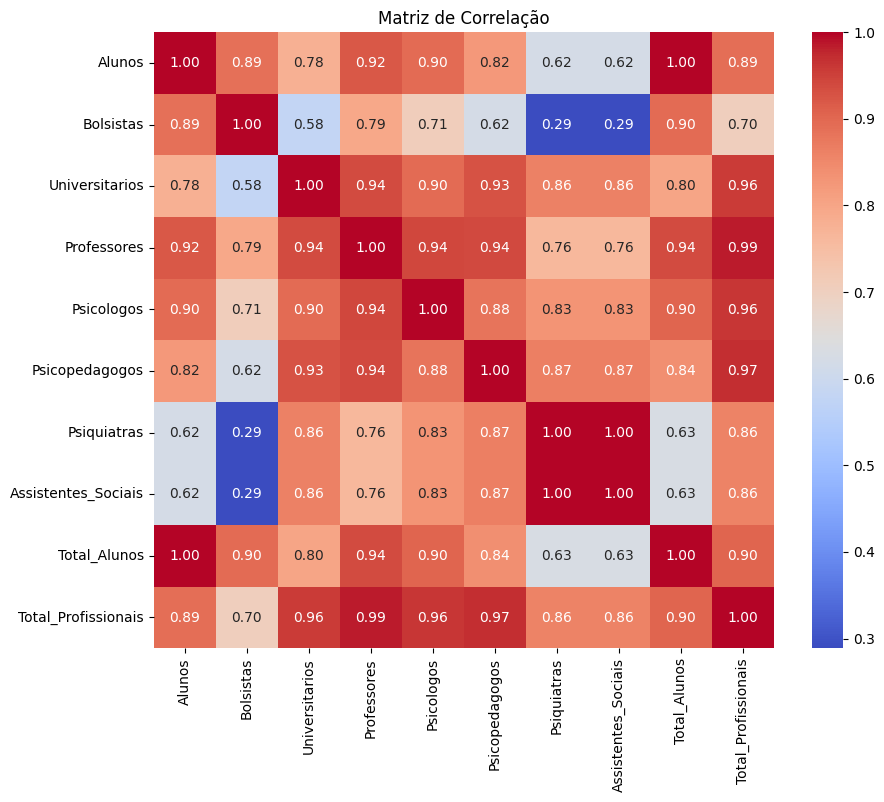

In [ ]:
# Removendo a coluna de ano
df_dados_sem_ano = df_dados_gerais.drop(columns=['Ano'])

# Calculando a matriz de correlação
correlation_matrix = df_dados_sem_ano.corr()

# Criando um heatmap com Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação')
plt.show()


# Forecast

In [ ]:
# Dados existentes
anos_exist = df_dados_gerais['Ano'].values
alunos_exist = df_dados_gerais['Alunos'].values

# Previsão com média móvel simples
media_movel = np.mean(alunos_exist)
forecast_media_movel = np.full(len(anos_exist) + 5, media_movel)

# Previsão com regressão linear simples
modelo_regressao = LinearRegression()
modelo_regressao.fit(anos_exist.reshape(-1, 1), alunos_exist)
anos_futuros_regressao = np.arange(anos_exist[0], anos_exist[-1] + 6).reshape(-1, 1)
forecast_regressao = modelo_regressao.predict(anos_futuros_regressao)

# Previsão com método Naive
last_observation = alunos_exist[-1]
forecast_naive = np.full(len(anos_exist) + 5, last_observation)

# Previsão com Random Forest
modelo_random_forest = RandomForestRegressor()
modelo_random_forest.fit(anos_exist.reshape(-1, 1), alunos_exist)
anos_futuros_rf = np.arange(anos_exist[0], anos_exist[-1] + 6).reshape(-1, 1)
forecast_random_forest = modelo_random_forest.predict(anos_futuros_rf)

# Previsão com suavização exponencial simples
modelo_suav_exp = SimpleExpSmoothing(alunos_exist)
resultado_suav_exp = modelo_suav_exp.fit()
forecast_suav_exp = resultado_suav_exp.forecast(len(anos_exist) + 5)

# Criando o gráfico com Plotly
fig = go.Figure()

# Adicionando dados existentes
fig.add_trace(go.Scatter(x=anos_exist, y=alunos_exist, mode='lines+markers', name='Total de Alunos', line=dict(width=3)))

# Adicionando previsões
fig.add_trace(go.Scatter(x=anos_futuros_regressao.flatten(), y=forecast_media_movel, mode='lines', name='Média Móvel Simples', line=dict(dash='dash', width=1)))
fig.add_trace(go.Scatter(x=anos_futuros_regressao.flatten(), y=forecast_regressao, mode='lines', name='Regressão Linear Simples', line=dict(dash='dash', color='green', width=1)))
fig.add_trace(go.Scatter(x=anos_futuros_regressao.flatten(), y=forecast_naive, mode='lines', name='Método Naive', line=dict(dash='dash', width=1)))
fig.add_trace(go.Scatter(x=anos_futuros_regressao.flatten(), y=forecast_random_forest, mode='lines', name='Random Forest', line=dict(dash='dash', width=1)))
fig.add_trace(go.Scatter(x=anos_futuros_regressao.flatten(), y=forecast_suav_exp, mode='lines', name='Suavização Exponencial Simples', line=dict(dash='dash', width=1)))
# Adicione as previsões restantes aqui

# Personalizando layout
fig.update_layout(title='Previsões de Alunos desde o Início até os Próximos 5 Anos',
                  xaxis_title='Ano',
                  yaxis_title='Total de Alunos')

# Exibindo o gráfico
fig.show()


## Regressão Linear Simples

In [ ]:
# Criando o gráfico com Plotly
fig = go.Figure()

# Adicionando dados existentes
fig.add_trace(go.Scatter(x=anos_exist, y=alunos_exist, mode='lines+markers', name='Dados Exist.'))

# Adicionando previsões
fig.add_trace(go.Scatter(x=anos_futuros_regressao.flatten(), y=forecast_regressao, mode='lines', name='Regressão Linear Simples', line=dict(dash='dash', color='green')))


# Personalizando layout
fig.update_layout(title='Total de Alunos + Regressão Linear Simples (5 anos)',
                  xaxis_title='Ano',
                  yaxis_title='Total de Alunos')

# Exibindo o gráfico
fig.show()

## Cenários What-if 

In [ ]:
# Definindo o fator de aumento (em decimal, por exemplo, 0.1 para um aumento de 10%)
aumento = 0.5  # Isso representa um aumento de 10% TODO: receber como parâmetro no Streamlit
anos = 10

# Aplicando o aumento ao conjunto de dados original
alunos_exist_aumento = alunos_exist * (1 + aumento)

# Ajustando a regressão linear ao conjunto de dados com aumento
modelo_regressao_aumento = LinearRegression()
modelo_regressao_aumento.fit(anos_exist.reshape(-1, 1), alunos_exist_aumento)

anos_futuros_regressao = np.arange(anos_exist[0], anos_exist[-1] + anos).reshape(-1, 1) #TODO: receber como parâmetro no Streamlit o número de anos
forecast_regressao_aumento = modelo_regressao_aumento.predict(anos_futuros_regressao)

# Arredondando os valores de forecast_regressao_aumento para inteiros
forecast_regressao_aumento_int = np.round(forecast_regressao_aumento).astype(int)



# Criando o gráfico com Plotly
fig = go.Figure()

# Adicionando dados existentes
fig.add_trace(go.Scatter(x=anos_exist, y=alunos_exist, mode='lines+markers', name='Dados Exist.'))

# Adicionando previsões
fig.add_trace(go.Scatter(x=anos_futuros_regressao.flatten(), y=forecast_regressao_aumento_int, mode='lines', name='Regressão Linear Simples', line=dict(dash='dash', color='green')))


# Personalizando layout
fig.update_layout(title='Cenários de Crescimento (What-if)',
                  xaxis_title='Ano',
                  yaxis_title='Total de Alunos')

# Exibindo o gráfico
fig.show()

# Conclusão